In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  as mpl
import h5py
import matplotlib.colors as colors
from tqdm import tqdm
from scipy import stats
import cmasher as cmr
import seaborn as sns
import warnings
import multiprocessing as mp
from functools import partial
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from matplotlib.colors import Normalize

import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

from matplotlib.colors import LogNorm

In [2]:
from msafit.model.config import get_default_config
params = get_default_config()
params['instrument']['filter'] = "F170LP"
params['instrument']['disperser'] = "G235H"

from msafit.fpa import PSFLib
psfs = PSFLib('1x3_G235H_Q3_PSFLib.fits')
params["grid"]["x_grid"] = psfs.psf_x
params["grid"]["y_grid"] = psfs.psf_y
params["grid"]["wave_grid"] = psfs.psf_wave

from msafit.model import Sersic
# create a model cube I(x,y,lambda)
model = Sersic(params)
model(params["grid"]["wave_grid"])

_param_dict = model._param_dict
x_grid_bins = _param_dict['grid']['x_grid_sky'][0,:]
y_grid_bins = _param_dict['grid']['y_grid_sky'][:,0]

In [3]:
def Defining_new_coords (Coord_stars,mp,R_star) : 

    # Initialing tensor Mij
    Mijup = np.zeros((3, 3))
    Mijdown = np.zeros((3, 3))

    radius = np.sqrt(np.sum(Coord_stars**2, axis=1))
    
    radius_cond = radius <= R_star*6
    if mp[radius_cond] is None or len(mp) < 1000:
        radius_cond = radius <= R_star*8
        if mp[radius_cond] is None or len(mp) < 1000:
            radius_cond = radius <= R_star*10
            if mp[radius_cond] is None or len(mp) < 1000:
                radius_cond = radius <= R_star*12
                if mp[radius_cond] is None or len(mp) < 1000:
                    radius_cond = radius <= R_star*14
                    if mp[radius_cond] is None or len(mp) < 1000:
                        radius_cond = radius <= R_star*16
                        if mp[radius_cond] is None or len(mp) < 1000:
                            radius_cond = radius <= R_star*18
                            if mp[radius_cond] is None or len(mp) < 1000:
                                radius_cond = radius <= R_star*20
                                if mp[radius_cond] is None or len(mp) < 1000:
                                    return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    for i in range(3):
        rpi = Coord_stars[:, i]
        for j in range(3):
            rpj = Coord_stars[:, j]

            Mijup[i, j] = np.sum(mp[radius_cond] * rpi[radius_cond] * rpj[radius_cond])
            Mijdown[i, j] = np.sum(mp[radius_cond])

    Mij = Mijup / Mijdown
        
    eigenvalues, eigenvectors = np.linalg.eig(Mij)

    Axis_length = np.sqrt(eigenvalues)

    a = np.max(Axis_length)
    c = np.min(Axis_length)
    b_cond = np.where((Axis_length > c) & (Axis_length < a))
    b = (Axis_length[b_cond])[0]

    # Initialize ratios
    old_ca_ratio = c / a
    old_ba_ratio = b / a

    # Set convergence threshold
    convergence_threshold = 0.01

    old_a = a
    old_b = b
    old_c = c

    anti_infinit_break = 0

    while True:
        rp_newframe = np.array([transform_particle_coords(particle_coords, eigenvectors) for particle_coords in Coord_stars])
        sorted_indices = np.argsort(eigenvalues)[::-1]
        x, y, z = rp_newframe[:, sorted_indices[0]], rp_newframe[:, sorted_indices[1]], rp_newframe[:, sorted_indices[2]]
        q = b/a
        s = c/a
    
        rp_wave = (x)**2 + (y**2/q**2) + (z**2/s**2)

        r_max = (((old_a**2)/(old_b*old_c))**(2/3)) * ((30)**2)

        cond_rad_max = rp_wave <= r_max

        Mijrup = np.zeros((3, 3))
        Mijrdown = np.zeros((3, 3))

        for i in range(3):
            rpi = Coord_stars[:, i]
            for j in range(3):
                rpj = Coord_stars[:, j]
                Mijrup[i, j] = np.sum((mp[cond_rad_max]/rp_wave[cond_rad_max]) * rpi[cond_rad_max] * rpj[cond_rad_max])
                Mijrdown[i, j] = np.sum(mp[cond_rad_max]/rp_wave[cond_rad_max])

        Mijr = Mijrup / Mijrdown

        if np.any(np.isnan(Mijr)) or np.any(np.isinf(Mijr)):
            print('for subhalo = ',subhalo_id)
            raise ValueError("Mijr contains NaN or Inf values before eigen computation")
            
        
        eigenvalues, eigenvectors = np.linalg.eig(Mijr)
    
        Axis_length = np.sqrt(eigenvalues)
    
        int_a = np.max(Axis_length)
        int_c = np.min(Axis_length)
        int_b_cond = np.where((Axis_length > int_c) & (Axis_length < int_a))
        int_b = Axis_length[int(int_b_cond[0])]
    
        eigenvalues_scaled = eigenvalues

        Axis_length_scaled = np.sqrt(eigenvalues_scaled)* (((a*b*c)**(1/3))/((int_a*int_b*int_c)**(1/3)))

        new_a = np.max(Axis_length_scaled)
        new_c = np.min(Axis_length_scaled)
        b_cond = np.where((Axis_length_scaled > new_c) & (Axis_length_scaled < new_a))
        new_b = (Axis_length_scaled[int(b_cond[0])])

        new_ca_ratio = new_c / new_a
        new_ba_ratio = new_b / new_a

        fractional_change_ca = abs(new_ca_ratio - old_ca_ratio) / old_ca_ratio
        fractional_change_ba = abs(new_ba_ratio - old_ba_ratio) / old_ba_ratio

        epsilon = 1 - (new_c/new_a)
        Ttriaxial = ((new_a**2) - (new_b**2)) / ((new_a**2)-(new_c**2))
        
        if fractional_change_ca < convergence_threshold and fractional_change_ba < convergence_threshold:
            break
        
        if anti_infinit_break > 20:
                break

        old_ca_ratio = new_ca_ratio
        old_ba_ratio = new_ba_ratio

        old_a = a
        old_b = new_b
        old_c = new_c

        anti_infinit_break += 1

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices] 

    if any(v is None for v in [new_a, new_b, new_c, epsilon, Ttriaxial, eigenvectors]):
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    
    return (new_a, new_b, new_c, epsilon, Ttriaxial, eigenvectors) 
    

def transform_particle_coords(particle_coords, trans_matrix_scaled):
    return np.dot(particle_coords, trans_matrix_scaled)


def Gal_inf (ID,Snap,offset_x,offset_y):

    file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{Snap:03d}/snap_{Snap:03d}.0.hdf5'
    
    with h5py.File(file_path, 'r') as f:
        header = dict( f['Header'].attrs.items())
        
    z = header['Redshift']

    scaling_factor = 1.0 / (1+z)

    hubble_param = header['HubbleParam']
    H0 = hubble_param*100
    Omega_lamb = header['OmegaLambda']
    Omega_baryon = header['OmegaBaryon']
    Omega_0 = header['Omega0']

    basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"

    Subhalo = il.groupcat.loadSingle(basePath,Snap, subhaloID = ID)

    Subhalo_gas_part = il.snapshot.loadSubhalo(basePath, snapNum=Snap, id=ID, partType='gas', fields=["StarFormationRate","Masses","Coordinates","Velocities"])

    Starforming_cond = Subhalo_gas_part["StarFormationRate"] > 0

    Coord_gas = (Subhalo_gas_part["Coordinates"][Starforming_cond]-Subhalo["SubhaloPos"]) * scaling_factor / hubble_param

    new_a, new_b, new_c, epsilon, Ttriaxial, eigenvectors =  Defining_new_coords(Coord_gas,np.array(Subhalo_gas_part["Masses"])[Starforming_cond],Subhalo['SubhaloHalfmassRadType'][4])

    Coord_gas = transform_particle_coords(Coord_gas,eigenvectors)
    
    Coord_gas[:,0] = Coord_gas[:,0] + offset_x

    Coord_gas[:,2] = Coord_gas[:,2] + offset_y
    
    radius = np.sqrt(np.sum(Coord_gas**2, axis=1))
    
    Rad_cond  = radius < (0.4*Subhalo["SubhaloHalfmassRadType"][0])
    
    velocity_gas = ((Subhalo_gas_part["Velocities"][Starforming_cond])[:,2]*np.sqrt(scaling_factor)) - Subhalo["SubhaloVel"][2]

    SFR = Subhalo_gas_part["StarFormationRate"][Starforming_cond]
    
    return(Coord_gas[Rad_cond],velocity_gas[Rad_cond],SFR[Rad_cond],Omega_0, Omega_lamb, Omega_baryon, H0, z)


def Distances(Omega_0, Omega_baryon, H0, z):

    cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_0, Ob0=Omega_baryon)

    D_A = cosmo.angular_diameter_distance(z).to(u.Mpc)

    D_A_kpc = D_A.to(u.kpc)

    D_L = cosmo.luminosity_distance(z)

    D_A_val = D_A_kpc.value

    D_L = D_L.value
    
    return(D_A_val,D_L)


def Flux(SFR,Dl):

    L_sun_erg_per_s = 3.828e33

    L_Halpha = SFR/np.float64(7.9e-42*L_sun_erg_per_s) #Lo

    D_l = Dl  * 3.08567758e24 #Mpc to cm

    FHalpha = (L_Halpha / (4*np.pi*(D_l**2))) * L_sun_erg_per_s # erg.cm-2

    return (FHalpha)


def Delta_Lambda(v_z,z):
    
    H_alpha_wave = 6564.6 * (1+z) #Ångström

    c = 299792 #km/s

    delt_lamb = (v_z/c)*H_alpha_wave

    return(delt_lamb)


def xy_bins(x_grid_bins,y_grid_bins,DA): 

    bin_widthx = np.abs(x_grid_bins[0]) - np.abs(x_grid_bins[1]) 
    bin_widthy = np.abs(y_grid_bins[0]) - np.abs(y_grid_bins[1]) 
    
    bin_edges_for_x =  []
    bin_edges_for_y =  []

    bin_edges_for_x.append(x_grid_bins[0] - bin_widthx / 2)
    bin_edges_for_y.append(y_grid_bins[0] - bin_widthy / 2)

    
    for center in x_grid_bins:
        bin_edges_for_x.append(center + bin_widthx / 2)

    for center in y_grid_bins:
        bin_edges_for_y.append(center + bin_widthy / 2)

    bin_edges_for_x = np.array(bin_edges_for_x)
    bin_edges_for_y = np.array(bin_edges_for_y)
    
    angular_res_rad_x = bin_edges_for_x * (np.pi/(180*3600))

    angular_res_rad_y = bin_edges_for_y * (np.pi/(180*3600))

    Bin_edges_kpc_x = angular_res_rad_x * DA # d = theta * DA in kpc

    Bin_edges_kpc_y = angular_res_rad_y * DA # d = theta * DA in kpc

    return(Bin_edges_kpc_x,Bin_edges_kpc_y)


def Bins(v_z,speed_bin_size,x_bin,y_bin):

    bin_width_vz = speed_bin_size
    vz_min = np.nanmin(v_z)
    vz_max = np.nanmax(v_z)

    num_bins_v_z = int(np.ceil((vz_max - vz_min) / bin_width_vz))
    bin_edges_v_z = np.linspace(vz_min, vz_max, num_bins_v_z + 1)

    bin_centers_v_z = (bin_edges_v_z[:-1] + bin_edges_v_z[1:]) / 2
    
    Bin_edges = [x_bin,y_bin,bin_edges_v_z]
    
    return (Bin_edges,bin_centers_v_z)   


def Cube_maker (Coord,Lambda,flux,Bin_edges) :
    # Digitize the coordinates
    x_indices = np.digitize(Coord[:,0], Bin_edges[0]) - 1  # Subtract 1 to get zero-based index
    y_indices = np.digitize(Coord[:,2], Bin_edges[1]) - 1  # Subtract 1 to get zero-based index
    delta_lambda_indices = np.digitize(Lambda, Bin_edges[2]) - 1  # Subtract 1 to get zero-based index

    nb_x_bins = len(Bin_edges[0]) - 1
    nb_y_bins = len(Bin_edges[1]) - 1
    nb_delta_lambda_bins = len(Bin_edges[2]) - 1
    
    # Create the 3D array for accumulating flux values
    cube_3d = np.zeros((nb_x_bins, nb_y_bins, nb_delta_lambda_bins))
    
    # Accumulate flux into the bins
    for i in range(len(Coord[:,0])):
        if 0 <= x_indices[i] < nb_x_bins and 0 <= y_indices[i] < nb_y_bins and 0 <= delta_lambda_indices[i] < nb_delta_lambda_bins:
            cube_3d[x_indices[i], y_indices[i], delta_lambda_indices[i]] += flux[i]
    
    return (cube_3d)


def pipeline(ID, Snap, offset_x = 0, offset_y=0):
    speed_bin_size = float(input("Enter the bin size of speed in (km/s): "))
    
    Coord_gas,velocity_gas,SFR,Omega_0, Omega_lamb, Omega_baryon, H0, Z = Gal_inf(ID,Snap,offset_x,offset_y)
    DA,Dl = Distances(Omega_0, Omega_baryon, H0, Z)
    FHalpha = Flux(SFR,Dl)
    x_bin,y_bin = xy_bins(x_grid_bins,y_grid_bins,DA)
    Bin_edges,bin_centers_v_z = Bins(velocity_gas,speed_bin_size,x_bin,y_bin)
    Lambda = Delta_Lambda(velocity_gas,Z)
    bin_edges_lambda = Delta_Lambda(Bin_edges[2],Z)
    bin_centers_lambda = Delta_Lambda(bin_centers_v_z,Z)
    Bin_edges[2] = bin_edges_lambda
    cube = Cube_maker(Coord_gas,Lambda,FHalpha,Bin_edges)
    
    return(cube,Bin_edges,bin_centers_lambda,Z)

In [4]:
ID = 2
Snap = 33
#Snap_nums = [99, 50, 33, 25, 21, 17, 13] #z = 0,1,2,3,4,5,6

offset_x = 0#kpc
offset_y = 0 #kpc

In [5]:
cube,Bin_edges,bin_centers_lambda,Z = pipeline(ID,Snap,offset_x,offset_y)

Enter the bin size of speed in (km/s):  10


/tmp/ipykernel_66911/2965176599.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int_b = Axis_length[int(int_b_cond[0])]
/tmp/ipykernel_66911/2965176599.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_b = (Axis_length_scaled[int(b_cond[0])])


In [6]:
Squished_cube = np.nansum(cube, axis=2)
Squished_cube_x_lamb = np.nansum(cube, axis=1)
Total_flux = np.nansum(Squished_cube)
Mean_flux = np.nanmean(Squished_cube)

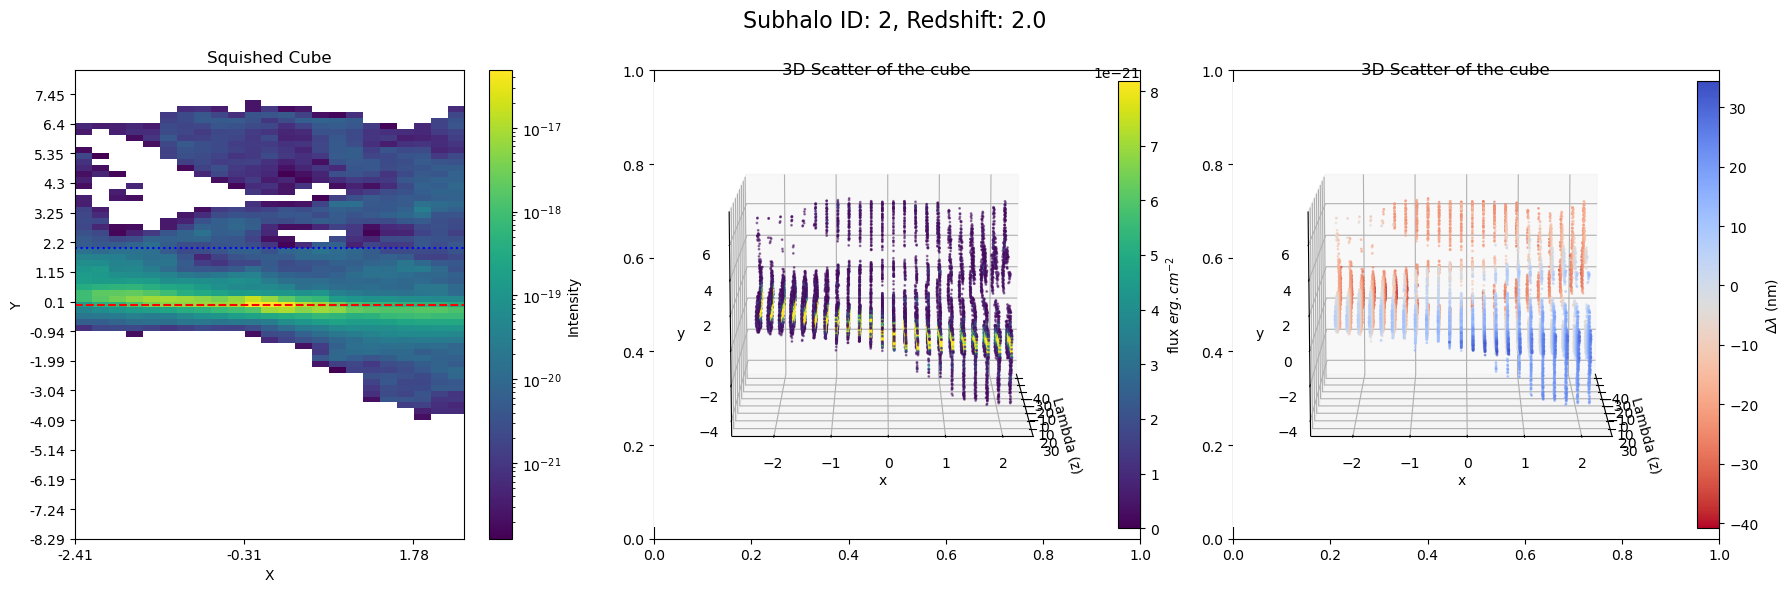

In [7]:
# Extracting one value per row from Squished_cube
extracted_values = Squished_cube[:, 0]

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Squished_cube on the left subplot
extent = [Bin_edges[0][0], Bin_edges[0][-1], Bin_edges[1][0], Bin_edges[1][-1]]

im = axes[0].imshow(Squished_cube.T, cmap='viridis', norm=LogNorm(), aspect='auto', extent=extent, origin='lower')
axes[0].set_title('Squished Cube')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Setting x and y ticks to the actual bin edges
axes[0].set_xticks(Bin_edges[0][::10])  # Adjust the step as needed for readability
axes[0].set_xticklabels(np.round(Bin_edges[0][::10], 2))
axes[0].set_yticks(Bin_edges[1][::5])  # Adjust the step as needed for readability
axes[0].set_yticklabels(np.round(Bin_edges[1][::5], 2))
axes[0].grid(False)
axes[0].axhline(y=0, color='red', linestyle='--')   # Vertical line at x = 0
axes[0].axhline(y=2, color='blue', linestyle=':') # Vertical line at x = 0.5

cbar0 = plt.colorbar(im, ax=axes[0], label='Intensity')  # Add a color bar to show the mapping of values to colors

# Plot 3D scatter plot of the cube on the middle subplot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
x, y, z = np.nonzero(cube)
flux_cube = cube[x, y, z]  # Flux values

# Normalize the flux values for color mapping
norm = Normalize(vmin=0, vmax=np.percentile(cube[x, y, z], 80))

# Plot scatter points with colormap
scatter = ax1.scatter(Bin_edges[2][z], Bin_edges[0][x],Bin_edges[1][y], c=flux_cube, cmap='viridis', s=1, alpha=0.5, norm=norm)
ax1.set_title('3D Scatter of the cube')
ax1.set_xlabel('Lambda (z)')
ax1.set_ylabel('x')
ax1.set_zlabel('y')

# Add color bar for the scatter plot
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label(r'flux $erg.cm^{-2}$')

# Adjusting the viewing angle
ax1.view_init(elev=10, azim=0)

# Plot 3D scatter plot of the cube on the right subplot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
x, y, z = np.nonzero(cube)

# Normalize Lambda values for color mapping
norm2 = Normalize(vmin=np.min(Bin_edges[2]), vmax=np.max(Bin_edges[2]))

# Plot scatter points with colormap
scatter = ax2.scatter(Bin_edges[2][z], Bin_edges[0][x],Bin_edges[1][y], c=Bin_edges[2][z], cmap='coolwarm_r', s=1, alpha=0.5)
ax2.set_title('3D Scatter of the cube')
ax2.set_xlabel('Lambda (z)')
ax2.set_ylabel('x')
ax2.set_zlabel('y')

# Add color bar for the scatter plot
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap='coolwarm_r'), ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label(r'$\Delta \lambda$ (nm)')

# Adjusting the viewing angle
ax2.view_init(elev=10, azim=0)

# Add the main title
fig.suptitle(f'Subhalo ID: {ID}, Redshift: {Z:.1f}', fontsize=16)

plt.tight_layout()
plt.show()

In [8]:
np.save('/u/flolac/Cube_datas/cube_data.npy', cube)
np.savez('/u/flolac/Cube_datas/Bin_edges.npz', x=Bin_edges[0], y=Bin_edges[1], lambda_=Bin_edges[2])
np.save('/u/flolac/Cube_datas/bin_centers_lambda.npy', bin_centers_lambda)

In [9]:
bin_centers_lambda

array([-40.53773378, -39.88278447, -39.22783515, -38.57288584,
       -37.91793653, -37.26298721, -36.6080379 , -35.95308859,
       -35.29813927, -34.64318996, -33.98824065, -33.33329133,
       -32.67834202, -32.02339271, -31.36844339, -30.71349408,
       -30.05854477, -29.40359545, -28.74864614, -28.09369683,
       -27.43874751, -26.7837982 , -26.12884889, -25.47389957,
       -24.81895026, -24.16400094, -23.50905163, -22.85410232,
       -22.199153  , -21.54420369, -20.88925438, -20.23430506,
       -19.57935575, -18.92440644, -18.26945712, -17.61450781,
       -16.9595585 , -16.30460918, -15.64965987, -14.99471056,
       -14.33976124, -13.68481193, -13.02986262, -12.3749133 ,
       -11.71996399, -11.06501468, -10.41006536,  -9.75511605,
        -9.10016674,  -8.44521742,  -7.79026811,  -7.1353188 ,
        -6.48036948,  -5.82542017,  -5.17047085,  -4.51552154,
        -3.86057223,  -3.20562291,  -2.5506736 ,  -1.89572429,
        -1.24077497,  -0.58582566,   0.06912365,   0.72